# Run AR6-fair for some new scenarios
# Here we attempt to read in emk files for the 2021 IEA scenarios
    - IEA net zero
    We use ssp126 to fill in the missing gases and then use these scenarios for the missing ones. 


In [5]:
import fair
import matplotlib.pyplot as pl
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.interpolate import interp1d
from multiprocessing import Pool
from tqdm import tqdm
import json
import pickle
import copy
import glob
#from climateforcing.twolayermodel import TwoLayerModel
from climateforcing.utils import check_and_download, mkdir_p

In [6]:
# set up plotting
pl.rcParams['figure.figsize'] = (9/2.54, 9/2.54)
pl.rcParams['font.size'] = 12
pl.rcParams['font.family'] = 'Arial'
pl.rcParams['xtick.direction'] = 'out'
pl.rcParams['ytick.direction'] = 'out'
pl.rcParams['xtick.minor.visible'] = True
pl.rcParams['ytick.major.left'] = True
pl.rcParams['ytick.major.right'] = True
pl.rcParams['ytick.minor.visible'] = True
pl.rcParams['xtick.top'] = True
pl.rcParams['ytick.right'] = True

In [7]:
# Download FaIR params set
check_and_download(
    'https://zenodo.org/record/5513022/files/fair-1.6.2-wg3-params.json', 
    '../data_input/fair_ar6/'
)

In [9]:
with open('../data_input/fair_ar6/fair-1.6.2-wg3-params.json') as f:
    config_list = json.load(f)

In [10]:
len(config_list)

2237

# Read in IEA scenarios
FossilCO2  
OtherCO2       
CH4       
N2O       
NOx     
NMVOC        
CO       
SOx    
CF4      
C2F6    
HFC125   
HFC134a   
HFC143a  
HFC227ea  
HFC245fa       
SF6

In [11]:
#ccc_emissions_file = '/net/home/h02/hadcam/fcm/python3/FaIR_ar6/Scenarios/CCC_rms_PA_scenario_161020.EMK'
#sr15_overshoot


def read_emk(rcp, hist=''):
    """Read in the data from EMK files"""

    with open(rcp, 'r') as f:
        data = f.readlines()

    if hist == 1:
        rDAT = np.zeros([15,19]) # dimensions dependant on year range
        row = 0
        Rrow = 0
        for line in data:
            if row >= 5:
                a = line.split()
                Gid = 0 # gas id
                for d in a:
                    rDAT[Rrow,Gid] = float(d)
                    Gid = Gid + 1
                Rrow = Rrow + 1
            row = row + 1
    else:
        rDAT = np.zeros([11,19]) # dimensions dependant on year range
        row = 0
        Rrow = 0
        for line in data:
            if row >= 5:
                a = line.split()

                if int(a[0]) >= 2005 and int(a[0]) <= 2100:
                    if int(a[0]) == 2005 or int(a[0])%10 == 0:
                        Gid = 0 # gas id
                        for d in a:
                            rDAT[Rrow,Gid] = float(d)
                            Gid = Gid + 1
                        Rrow = Rrow + 1
            row = row + 1

    return rDAT

#scenario_data = read_emk(emissions_file, hist='')
species = {0:'FossilCO2',
           1:'OtherCO2',
           2:'CH4',
           3:'N2O',
           4:'SOx', 
           5:'CO', 
           6:'NMVOC',
           7:'NOx',
           8:'CF4',
           9:'C2F6',
           10:'HFC125',   
           11:'HFC134a',   
           12:'HFC143a',  
           13:'HFC227ea',
           14:'HFC245fa', 
           15:'SF6'
          }
#print (scenario_data)

In [12]:
scenarios = ['ssp119','ssp126']
newscenarios = ['NZ','APS','SDS','STEPS','CCC_PA']

In [16]:
# Download RCMIP emissions
check_and_download(
    'https://zenodo.org/record/4589756/files/rcmip-emissions-annual-means-v5-1-0.csv', 
    '../data_input/rcmip/'
)

In [18]:
ssp_df = pd.read_csv('../data_input/rcmip/rcmip-emissions-annual-means-v5-1-0.csv')
years = np.arange(1750, 2111)

startyear = 1750
first_scenyear = 2015
last_scenyear = 2110
first_row = int(first_scenyear-startyear)
last_row = int(last_scenyear-startyear)

species = [  # in fair 1.6, order is important
    '|CO2|MAGICC Fossil and Industrial',
    '|CO2|MAGICC AFOLU',
    '|CH4',
    '|N2O',
    '|Sulfur',
    '|CO',
    '|VOC',
    '|NOx',
    '|BC',
    '|OC',
    '|NH3',
    '|CF4',
    '|C2F6',
    '|C6F14',
    '|HFC23',
    '|HFC32',
    '|HFC4310mee',
    '|HFC125',
    '|HFC134a',
    '|HFC143a',
    '|HFC227ea',
    '|HFC245fa',
    '|SF6',
    '|CFC11',
    '|CFC12',
    '|CFC113',
    '|CFC114',
    '|CFC115',
    '|CCl4',
    '|CH3CCl3',
    '|HCFC22',
    '|HCFC141b',
    '|HCFC142b',
    '|Halon1211',
    '|Halon1202',
    '|Halon1301',
    '|Halon2402',
    '|CH3Br',
    '|CH3Cl',
]

# Assume that units coming out of aneris don't change. One day I'll do unit parsing
unit_convert = np.ones(40)
unit_convert[1] = 12/44/1000
unit_convert[2] = 12/44/1000
unit_convert[4] = 28/44/1000
unit_convert[5] = 32/64
unit_convert[8] = 14/46

data_out = {}
# 'ssp119','ssp126','ssp245','ssp370',ssp434','ssp585''

for scenario in scenarios:
    data_out[scenario] = np.ones((361, 40)) * np.nan
    data_out[scenario][:,0] = years
    print(scenario)
    years_future = [2015] + list(range(2020,2111,10))
    for i, specie in enumerate(species):
        
        data_out[scenario][:first_row,i+1] = ssp_df.loc[(ssp_df['Region']=='World')&(ssp_df['Scenario']==scenario)&(ssp_df['Variable'].str.endswith(specie)),str(startyear):'2014']*unit_convert[i+1]
        f = interp1d(years_future, ssp_df.loc[(ssp_df['Region']=='World')&(ssp_df['Scenario']==scenario)&(ssp_df['Variable'].str.endswith(specie)),'2015':'2110'].dropna(axis=1))
        data_out[scenario][first_row:(last_row+1), i+1] = f(np.arange(first_scenyear, last_scenyear+1))*unit_convert[i+1]

ssp119
ssp126


# ssp119

In [19]:
results_out = {}

In [20]:
updated_config = []
for i, cfg in enumerate(config_list):
    updated_config.append({})
    for key, value in cfg.items():
        if isinstance(value, list):
            updated_config[i][key] = np.asarray(value)
        else:
            updated_config[i][key] = value
    updated_config[i]['emissions'] = data_out['ssp119']
    updated_config[i]['diagnostics'] = 'AR6'
    updated_config[i]["efficacy"] = np.ones(45)
    updated_config[i]["gir_carbon_cycle"] = True
    updated_config[i]["temperature_function"] = "Geoffroy"
    updated_config[i]["aerosol_forcing"] = "aerocom+ghan2"
    updated_config[i]["fixPre1850RCP"] = False
    updated_config[i]["scale"][43] = 0.6

In [21]:
def run_fair(args):
    thisC, thisF, thisT, _, thisOHU, _, thisAF = fair.forward.fair_scm(**args)
    return (thisC[:,0], thisT, np.sum(thisF[:,:43], axis=1), np.sum(thisF[:,35:41], axis=1), np.sum(thisF, axis=1))

if __name__ == '__main__':
    with Pool(28) as pool:
        result = list(tqdm(pool.imap(run_fair, updated_config), total=len(updated_config)))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [01:15<00:00, 29.64it/s]


In [23]:
results_out['ssp119'] = {}
result_t = np.array(result).transpose(1,2,0)
c, t, f_ant, f_aer, f_tot = result_t
temp_rebase = t - t[100:151,:].mean(axis=0)
results_out['ssp119']['co2_conc'] = c
results_out['ssp119']['temp'] = temp_rebase
results_out['ssp119']['F_ant'] = f_ant
results_out['ssp119']['F_aer'] = f_aer
results_out['ssp119']['F_tot'] = f_tot

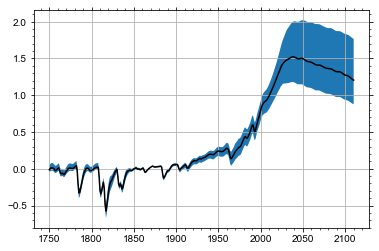

In [24]:
pl.fill_between(np.arange(1750,2111), np.percentile(results_out['ssp119']['temp'], 5, axis=1), np.percentile(results_out['ssp119']['temp'], 95, axis=1))
pl.plot(np.arange(1750,2111), np.percentile(results_out['ssp119']['temp'], 50, axis=1), color='k')
pl.grid()

# ssp126

In [25]:
updated_config = []
for i, cfg in enumerate(config_list):
    updated_config.append({})
    for key, value in cfg.items():
        if isinstance(value, list):
            updated_config[i][key] = np.asarray(value)
        else:
            updated_config[i][key] = value
    updated_config[i]['emissions'] = data_out['ssp126']
    updated_config[i]['diagnostics'] = 'AR6'
    updated_config[i]["efficacy"] = np.ones(45)
    updated_config[i]["gir_carbon_cycle"] = True
    updated_config[i]["temperature_function"] = "Geoffroy"
    updated_config[i]["aerosol_forcing"] = "aerocom+ghan2"
    updated_config[i]["fixPre1850RCP"] = False
    updated_config[i]["scale"][43] = 0.6

In [26]:
def run_fair(args):
    thisC, thisF, thisT, _, thisOHU, _, thisAF = fair.forward.fair_scm(**args)
    return (thisC[:,0], thisT, np.sum(thisF[:,:43], axis=1), np.sum(thisF[:,35:41], axis=1), np.sum(thisF, axis=1))

if __name__ == '__main__':
    with Pool(28) as pool:
        result = list(tqdm(pool.imap(run_fair, updated_config), total=len(updated_config)))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [01:25<00:00, 26.02it/s]


In [27]:
results_out['ssp126'] = {}
result_t = np.array(result).transpose(1,2,0)
c, t, f_ant, f_aer, f_tot = result_t
temp_rebase = t - t[100:151,:].mean(axis=0)
results_out['ssp126']['co2_conc'] = c
results_out['ssp126']['temp'] = temp_rebase
results_out['ssp126']['F_ant'] = f_ant
results_out['ssp126']['F_aer'] = f_aer
results_out['ssp126']['F_tot'] = f_tot

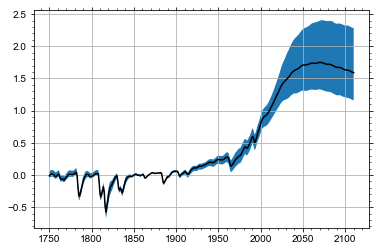

In [28]:
pl.fill_between(np.arange(1750,2111), np.percentile(results_out['ssp126']['temp'], 5, axis=1), np.percentile(results_out['ssp126']['temp'], 95, axis=1))
pl.plot(np.arange(1750,2111), np.percentile(results_out['ssp126']['temp'], 50, axis=1), color='k')
pl.grid()

# IEA EMK file as test

In [29]:
emkfile = '/net/home/h02/hadcam/fcm/python3/FaIR_ar6/Scenarios/MAGICC_FAIR_CM/IEA_rms_IEA_NZ_021121.EMK'

In [30]:
def annual_from_emk(emkfile=emkfile):
    """
    Read in emk files and return as annual emissions for FAIR
    Code from Dan
    """

    #Read emk file
    with open(emkfile, 'r') as f: data = f.readlines()
    
    nyears = int(data[0][:-1])
    scenario = data[1][:-1]
    SO2_1990 = 67.9 #float(data[2][:-1].split('=')[1])
    gas_name = data[3][:-1].split()
    units = data[4].split()
    
    #make and fill working variable for emk data
    emkdatR = np.zeros([nyears, 19])
    for i, x in enumerate(data[5:]): emkdatR[i,:] =  np.array(x[:-1].split(), dtype=np.float32)
    
    #Interpolate to annual
    yn = int(emkdatR[:,0].min())
    yx = int(emkdatR[:,0].max())
    emkdat = np.zeros([yx-yn+1, emkdatR.shape[1]])
    emkdat[:,0] = range(yn, yx+1)
    for i in range(1,emkdatR.shape[1]): emkdat[:,i] = np.interp(emkdat[:,0], emkdatR[:,0], emkdatR[:,i])


    #dictionary version
    emk={\
    'year':emkdat[:,0], \
    'co2_fossil':emkdat[:,1], \
    'co2_land':emkdat[:,2], \
    'ch4':emkdat[:,3], \
    'n2o':emkdat[:,4], \
    'nox':emkdat[:,5], \
    'nmvoc':emkdat[:,6], \
    'co': emkdat[:,7], \
    'sox':emkdat[:,8], \
    'cf4':emkdat[:,11], \
    'c2f6': emkdat[:,12], \
    'hfc125': emkdat[:,13], \
    'hfc134a': emkdat[:,14], \
    'hfc143a': emkdat[:,15], \
    'hfc227ea': emkdat[:,16], \
    'hfc245fa': emkdat[:,17], \
    'sf6': emkdat[:,18], \
    }


    blank = np.zeros([yx-yn+1]) # to fill in the missing species

    class Emissions:
        year      = emk['year']
        co2_fossil= emk['co2_fossil'] 
        co2_land  = emk['co2_land'] 
        co2       = (emk['co2_fossil'] + emk['co2_land'] ) 
        ch4       = emk['ch4']
        n2o       = emk['n2o'] # UNITS? * 28. / 44.
        sox       = emk['sox'] + SO2_1990
        co        = emk['co']
        nmvoc     = emk['nmvoc']
        nox       = emk['nox']
        bc        = blank[:] # sum of these in 1990 is assumed 0.1
        oc        = blank[:] # should scale with SOX
        nh3       = blank[:]
        cf4       = emk['cf4']
        c2f6      = emk['c2f6']
        c6f14     = blank[:]
        hfc23     = blank[:]
        hfc32     = blank[:]
        hfc43_10  = blank[:]
        hfc125    = emk['hfc125']
        hfc134a   = emk['hfc134a']
        hfc143a   = emk['hfc143a']
        hfc227ea  = emk['hfc227ea']
        hfc245fa  = emk['hfc245fa']
        sf6       = emk['sf6']
        cfc11     = blank[:]
        cfc12     = blank[:]
        cfc113    = blank[:]
        cfc114    = blank[:]
        cfc115    = blank[:]
        carb_tet  = blank[:]
        mcf       = blank[:]
        hcfc22    = blank[:]
        hcfc141b  = blank[:]
        hcfc142b  = blank[:]
        halon1211 = blank[:]
        halon1202 = blank[:]
        halon1301 = blank[:]
        halon2402 = blank[:]
        ch3br     = blank[:]
        ch3cl     = blank[:]

        emissions = np.zeros([yx-yn+1,40])
        emissions[:,0] = emk['year']
        emissions[:,1] = emk['co2_fossil'] 
        emissions[:,2] = emk['co2_land'] 
        emissions[:,3] = emk['ch4']
        emissions[:,4] = emk['n2o'] # UNITS? * 28. / 44.
        emissions[:,5] = emk['sox'] + SO2_1990
        emissions[:,6] = emk['co']
        emissions[:,7] = emk['nmvoc']
        emissions[:,8] = emk['nox']
        emissions[:,9] = blank[:] # sum of these in 1990 is assumed 0.1
        emissions[:,10] = blank[:] # should scale with SOX
        emissions[:,11] = blank[:]
        emissions[:,12] = emk['cf4']
        emissions[:,13] = emk['c2f6']
        emissions[:,14] = blank[:]
        emissions[:,15] = blank[:]
        emissions[:,16] = blank[:]
        emissions[:,17] = blank[:]
        emissions[:,18] = emk['hfc125']
        emissions[:,19] = emk['hfc134a']
        emissions[:,20] = emk['hfc143a']
        emissions[:,21] = emk['hfc227ea']
        emissions[:,22] = emk['hfc245fa']
        emissions[:,23] = emk['sf6']
        emissions[:,24] = blank[:]
        emissions[:,25] = blank[:]
        emissions[:,26] = blank[:]
        emissions[:,27] = blank[:]
        emissions[:,28] = blank[:]
        emissions[:,29] = blank[:]
        emissions[:,30] = blank[:]
        emissions[:,31] = blank[:]
        emissions[:,32] = blank[:]
        emissions[:,33] = blank[:]
        emissions[:,34] = blank[:]
        emissions[:,35] = blank[:]
        emissions[:,36] = blank[:]
        emissions[:,37] = blank[:]
        emissions[:,38] = blank[:]
        emissions[:,39] = blank[:]


    return Emissions



In [31]:
def splice_to_historical(emiss, template):

    """
    Splice into a deep copy on an exisiting emissions profile.
    This is a quick way to infill and supplies historical emissions.

    NOTE: Missing GHGs are infilled form the template to choose carefully.
    """
    print(template.shape)
    
    output = copy.deepcopy(template)
    print(output.shape)

    #years to replace
    ID = np.where((template[:,0] >= emiss.emissions[0,0]) & (template[:,0] <= emiss.emissions[-1,0]))

    for i in range(1,40):
        if emiss.emissions[:,i].sum() != 0.0:
            output[ID,i] = emiss.emissions[:,i]


    return output
    

In [32]:
files=glob.glob('/home/h01/hadlg/MAGICC_FAIR_CM/IEA_rms_IEA_*_021121.EMK')
print(files)

['/home/h01/hadlg/MAGICC_FAIR_CM/IEA_rms_IEA_APS_021121.EMK', '/home/h01/hadlg/MAGICC_FAIR_CM/IEA_rms_IEA_NZ_021121.EMK', '/home/h01/hadlg/MAGICC_FAIR_CM/IEA_rms_IEA_SDS_021121.EMK', '/home/h01/hadlg/MAGICC_FAIR_CM/IEA_rms_IEA_STEPS_021121.EMK']


In [33]:
emiss = annual_from_emk(emkfile=emkfile)
newscenario = splice_to_historical(emiss, data_out['ssp119'])

(361, 40)
(361, 40)


In [34]:

# Need to link newscenario with data_out['sr15_overshoot']
data_out['NZ'] = newscenario

# Do I still need these unit conversions?
#unit_convert = np.ones(40)
#unit_convert[1] = 12/44/1000
#unit_convert[2] = 12/44/1000
#unit_convert[4] = 28/44/1000
#unit_convert[5] = 32/64
#unit_convert[8] = 14/46

#for scenario in scenarios:
#    for i, specie in enumerate(species):
#        print(specie)
#        data_out[scenario][:,i+1] = data_out['sr15_overshoot']*unit_convert[i+1]
#        f = interp1d(years, .dropna(axis=1))
#        data_out[scenario][first_row:(last_row+1), i+1] = f(np.arange(first_scenyear, last_scenyear+1))*unit_convert[i+1]

In [35]:
updated_config = []
for i, cfg in enumerate(config_list):
    updated_config.append({})
    for key, value in cfg.items():
        if isinstance(value, list):
            updated_config[i][key] = np.asarray(value)
        else:
            updated_config[i][key] = value
    updated_config[i]['emissions'] = data_out['NZ']
    updated_config[i]['diagnostics'] = 'AR6'
    updated_config[i]["efficacy"] = np.ones(45)
    updated_config[i]["gir_carbon_cycle"] = True
    updated_config[i]["temperature_function"] = "Geoffroy"
    updated_config[i]["aerosol_forcing"] = "aerocom+ghan2"
    updated_config[i]["fixPre1850RCP"] = False
    updated_config[i]["scale"][43] = 0.6

In [36]:
def run_fair(args):
    thisC, thisF, thisT, _, thisOHU, _, thisAF = fair.forward.fair_scm(**args)
    return (thisC[:,0], thisT, np.sum(thisF[:,:43], axis=1), np.sum(thisF[:,35:41], axis=1), np.sum(thisF, axis=1))

if __name__ == '__main__':
    with Pool(28) as pool:
        result = list(tqdm(pool.imap(run_fair, updated_config), total=len(updated_config)))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [01:13<00:00, 30.42it/s]


In [37]:
len(result[0])

5

In [38]:
result_t = np.array(result).transpose(1,2,0)

In [39]:
results_out['NZ'] = {}
c, t, f_ant, f_aer, f_tot = result_t
temp_rebase = t - t[100:151,:].mean(axis=0)
results_out['NZ']['co2_conc'] = c
results_out['NZ']['temp'] = temp_rebase
results_out['NZ']['F_ant'] = f_ant
results_out['NZ']['F_aer'] = f_aer
results_out['NZ']['F_tot'] = f_tot

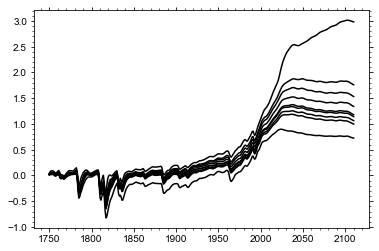

In [40]:
for perc in [0,5,10,20,25,50,75,90,100]:
    pl.plot(np.arange(1750,2111),np.percentile(t,perc, axis=1), color='k')


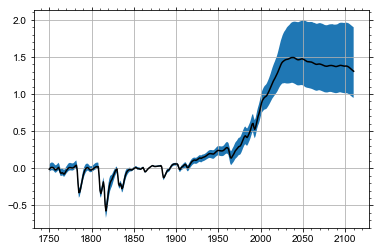

In [41]:
pl.fill_between(np.arange(1750,2111), np.percentile(results_out['NZ']['temp'], 5, axis=1), np.percentile(results_out['NZ']['temp'], 95, axis=1))
pl.plot(np.arange(1750,2111), np.percentile(results_out['NZ']['temp'], 50, axis=1), color='k')
pl.grid()

# Now do all IEA EMK files

In [42]:
import os

/home/h01/hadlg/MAGICC_FAIR_CM/IEA_rms_IEA_APS_021121.EMK
IEA_rms_IEA_APS_021121
APS
(361, 40)
(361, 40)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [01:24<00:00, 26.50it/s]


Item already exists:IEA_rms_IEA_APS_021121
/home/h02/hadcam/fcm/python3/FaIR_ar6/ar6/data_output_large/fair-samples/WEO-IEA/IEA_rms_IEA_APS_021121/APS_co2_conc.csv
/home/h02/hadcam/fcm/python3/FaIR_ar6/ar6/data_output_large/fair-samples/WEO-IEA/IEA_rms_IEA_APS_021121/APS_temp.csv
/home/h02/hadcam/fcm/python3/FaIR_ar6/ar6/data_output_large/fair-samples/WEO-IEA/IEA_rms_IEA_APS_021121/APS_F_ant.csv
/home/h02/hadcam/fcm/python3/FaIR_ar6/ar6/data_output_large/fair-samples/WEO-IEA/IEA_rms_IEA_APS_021121/APS_F_aer.csv
/home/h02/hadcam/fcm/python3/FaIR_ar6/ar6/data_output_large/fair-samples/WEO-IEA/IEA_rms_IEA_APS_021121/APS_F_tot.csv
/home/h01/hadlg/MAGICC_FAIR_CM/IEA_rms_IEA_NZ_021121.EMK
IEA_rms_IEA_NZ_021121
NZ
(361, 40)
(361, 40)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [01:17<00:00, 28.71it/s]


Item already exists:IEA_rms_IEA_NZ_021121
/home/h02/hadcam/fcm/python3/FaIR_ar6/ar6/data_output_large/fair-samples/WEO-IEA/IEA_rms_IEA_NZ_021121/NZ_co2_conc.csv
/home/h02/hadcam/fcm/python3/FaIR_ar6/ar6/data_output_large/fair-samples/WEO-IEA/IEA_rms_IEA_NZ_021121/NZ_temp.csv
/home/h02/hadcam/fcm/python3/FaIR_ar6/ar6/data_output_large/fair-samples/WEO-IEA/IEA_rms_IEA_NZ_021121/NZ_F_ant.csv
/home/h02/hadcam/fcm/python3/FaIR_ar6/ar6/data_output_large/fair-samples/WEO-IEA/IEA_rms_IEA_NZ_021121/NZ_F_aer.csv
/home/h02/hadcam/fcm/python3/FaIR_ar6/ar6/data_output_large/fair-samples/WEO-IEA/IEA_rms_IEA_NZ_021121/NZ_F_tot.csv
/home/h01/hadlg/MAGICC_FAIR_CM/IEA_rms_IEA_SDS_021121.EMK
IEA_rms_IEA_SDS_021121
SDS
(361, 40)
(361, 40)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [01:23<00:00, 26.64it/s]


Item already exists:IEA_rms_IEA_SDS_021121
/home/h02/hadcam/fcm/python3/FaIR_ar6/ar6/data_output_large/fair-samples/WEO-IEA/IEA_rms_IEA_SDS_021121/SDS_co2_conc.csv
/home/h02/hadcam/fcm/python3/FaIR_ar6/ar6/data_output_large/fair-samples/WEO-IEA/IEA_rms_IEA_SDS_021121/SDS_temp.csv
/home/h02/hadcam/fcm/python3/FaIR_ar6/ar6/data_output_large/fair-samples/WEO-IEA/IEA_rms_IEA_SDS_021121/SDS_F_ant.csv
/home/h02/hadcam/fcm/python3/FaIR_ar6/ar6/data_output_large/fair-samples/WEO-IEA/IEA_rms_IEA_SDS_021121/SDS_F_aer.csv
/home/h02/hadcam/fcm/python3/FaIR_ar6/ar6/data_output_large/fair-samples/WEO-IEA/IEA_rms_IEA_SDS_021121/SDS_F_tot.csv
/home/h01/hadlg/MAGICC_FAIR_CM/IEA_rms_IEA_STEPS_021121.EMK
IEA_rms_IEA_STEPS_021121
STEPS
(361, 40)
(361, 40)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [01:13<00:00, 30.59it/s]


Item already exists:IEA_rms_IEA_STEPS_021121
/home/h02/hadcam/fcm/python3/FaIR_ar6/ar6/data_output_large/fair-samples/WEO-IEA/IEA_rms_IEA_STEPS_021121/STEPS_co2_conc.csv
/home/h02/hadcam/fcm/python3/FaIR_ar6/ar6/data_output_large/fair-samples/WEO-IEA/IEA_rms_IEA_STEPS_021121/STEPS_temp.csv
/home/h02/hadcam/fcm/python3/FaIR_ar6/ar6/data_output_large/fair-samples/WEO-IEA/IEA_rms_IEA_STEPS_021121/STEPS_F_ant.csv
/home/h02/hadcam/fcm/python3/FaIR_ar6/ar6/data_output_large/fair-samples/WEO-IEA/IEA_rms_IEA_STEPS_021121/STEPS_F_aer.csv
/home/h02/hadcam/fcm/python3/FaIR_ar6/ar6/data_output_large/fair-samples/WEO-IEA/IEA_rms_IEA_STEPS_021121/STEPS_F_tot.csv


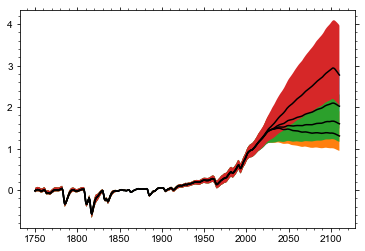

In [43]:
for file in files:
    print(file)
    model_scen_type_emk = file.split('/')[-1]
    model_scen_type = model_scen_type_emk.split('.')[0]
    print(model_scen_type)
    model_scen = model_scen_type.split('_')[3]
    print(model_scen)
    emiss = annual_from_emk(emkfile=file)
    newscenario = splice_to_historical(emiss, data_out['ssp119'])
    data_out[model_scen] = newscenario
    
    updated_config = []
    for i, cfg in enumerate(config_list):
        updated_config.append({})
        for key, value in cfg.items():
            if isinstance(value, list):
                updated_config[i][key] = np.asarray(value)
            else:
                updated_config[i][key] = value
        updated_config[i]['emissions'] = data_out[model_scen]
        updated_config[i]['diagnostics'] = 'AR6'
        updated_config[i]["efficacy"] = np.ones(45)
        updated_config[i]["gir_carbon_cycle"] = True
        updated_config[i]["temperature_function"] = "Geoffroy"
        updated_config[i]["aerosol_forcing"] = "aerocom+ghan2"
        updated_config[i]["fixPre1850RCP"] = False
        updated_config[i]["scale"][43] = 0.6
    
    def run_fair(args):
        thisC, thisF, thisT, _, thisOHU, _, thisAF = fair.forward.fair_scm(**args)
        return (thisC[:,0], thisT, np.sum(thisF[:,:43], axis=1), np.sum(thisF[:,35:41], axis=1), np.sum(thisF, axis=1))

    if __name__ == '__main__':
        with Pool(28) as pool:
            result = list(tqdm(pool.imap(run_fair, updated_config), total=len(updated_config)))
    
    results_out[model_scen] = {}
    result_t = np.array(result).transpose(1,2,0)
    c, t, f_ant, f_aer, f_tot = result_t
    temp_rebase = t - t[100:151,:].mean(axis=0)
    results_out[model_scen]['co2_conc'] = c
    results_out[model_scen]['temp'] = temp_rebase
    results_out[model_scen]['F_ant'] = f_ant
    results_out[model_scen]['F_aer'] = f_aer
    results_out[model_scen]['F_tot'] = f_tot

    pl.fill_between(np.arange(1750,2111), np.percentile(results_out[model_scen]['temp'], 5, axis=1), np.percentile(results_out[model_scen]['temp'], 95, axis=1))
    pl.plot(np.arange(1750,2111), np.percentile(results_out[model_scen]['temp'], 50, axis=1), color='k')
    pl.grid()
    
    model_archive = '/home/h02/hadcam/fcm/python3/FaIR_ar6/ar6/data_output_large/fair-samples/WEO-IEA/'    
    
    if os.path.isdir(model_archive+model_scen_type):
        print("Item already exists:" + str(model_scen_type))
    else:
        os.mkdir(model_archive+model_scen_type)
        print ("Making the model directory")
    
    model_dir = model_archive+model_scen_type+'/'
    
    for variable in results_out[model_scen].keys():
        years = 1750+np.arange(len(results_out[model_scen][variable]))
        header_text = np.insert(years, 0, 0)
        dic = results_out[model_scen][variable]
        filename=model_dir + model_scen+'_'+variable+'.csv'
        print(filename)
        pd.DataFrame(dic).T.reset_index().to_csv(filename, header=header_text, index=False)
    

# CCC paris agreement scenario

In [45]:
emkfile = '/net/home/h02/hadcam/fcm/python3/FaIR_ar6/Scenarios/CCC_rms_PA_scenario_161020.EMK'

In [46]:
def annual_from_emk_ccc(emkfile=emkfile):
    """
    Read in emk files and return as annual emissions for FAIR
    Code from Dan
    """

    #Read emk file
    with open(emkfile, 'r') as f: data = f.readlines()
    
    nyears = int(data[0][:-1])
    scenario = data[1][:-1]
    
    print('Line', nyears, scenario)
    
    SO2_1990 =  67.9 # float(data[2][:-1].split('=')[1])
    gas_name = data[3][:-1].split()
    units = data[4].split()
    
    #make and fill working variable for emk data
    emkdatR = np.zeros([nyears, 19])
    for i, x in enumerate(data[5:]): emkdatR[i,:] =  np.array(x[:-1].split(), dtype=np.float32)
    
    #Interpolate to annual
    yn = int(emkdatR[:,0].min())
    yx = int(emkdatR[:,0].max())
    emkdat = np.zeros([yx-yn+1, emkdatR.shape[1]])
    emkdat[:,0] = range(yn, yx+1)
    for i in range(1,emkdatR.shape[1]): emkdat[:,i] = np.interp(emkdat[:,0], emkdatR[:,0], emkdatR[:,i])


    #dictionary version
    emk={\
    'year':emkdat[:,0], \
    'co2_fossil':emkdat[:,1], \
    'co2_land':emkdat[:,2], \
    'ch4':emkdat[:,3], \
    'n2o':emkdat[:,4], \
    'nox':emkdat[:,5], \
    'nmvoc':emkdat[:,6], \
    'co': emkdat[:,7], \
    'sox':emkdat[:,8], \
    'cf4':emkdat[:,11], \
    'c2f6': emkdat[:,12], \
    'hfc125': emkdat[:,13], \
    'hfc134a': emkdat[:,14], \
    'hfc143a': emkdat[:,15], \
    'hfc227ea': emkdat[:,16], \
    'hfc245fa': emkdat[:,17], \
    'sf6': emkdat[:,18], \
    }


    blank = np.zeros([yx-yn+1]) # to fill in the missing species

    class Emissions:
        year      = emk['year']
        co2_fossil= emk['co2_fossil'] 
        co2_land  = emk['co2_land'] 
        co2       = (emk['co2_fossil'] + emk['co2_land'] ) 
        ch4       = emk['ch4']
        n2o       = emk['n2o'] # UNITS? * 28. / 44.
        sox       = emk['sox'] + SO2_1990
        co        = emk['co']
        nmvoc     = emk['nmvoc']
        nox       = emk['nox']
        bc        = blank[:] # sum of these in 1990 is assumed 0.1
        oc        = blank[:] # should scale with SOX
        nh3       = blank[:]
        cf4       = emk['cf4']
        c2f6      = emk['c2f6']
        c6f14     = blank[:]
        hfc23     = blank[:]
        hfc32     = blank[:]
        hfc43_10  = blank[:]
        hfc125    = emk['hfc125']
        hfc134a   = emk['hfc134a']
        hfc143a   = emk['hfc143a']
        hfc227ea  = emk['hfc227ea']
        hfc245fa  = emk['hfc245fa']
        sf6       = emk['sf6']
        cfc11     = blank[:]
        cfc12     = blank[:]
        cfc113    = blank[:]
        cfc114    = blank[:]
        cfc115    = blank[:]
        carb_tet  = blank[:]
        mcf       = blank[:]
        hcfc22    = blank[:]
        hcfc141b  = blank[:]
        hcfc142b  = blank[:]
        halon1211 = blank[:]
        halon1202 = blank[:]
        halon1301 = blank[:]
        halon2402 = blank[:]
        ch3br     = blank[:]
        ch3cl     = blank[:]

        emissions = np.zeros([yx-yn+1,40])
        emissions[:,0] = emk['year']
        emissions[:,1] = emk['co2_fossil'] 
        emissions[:,2] = emk['co2_land'] 
        emissions[:,3] = emk['ch4']
        emissions[:,4] = emk['n2o'] # UNITS? * 28. / 44.
        emissions[:,5] = emk['sox'] + SO2_1990
        emissions[:,6] = emk['co']
        emissions[:,7] = emk['nmvoc']
        emissions[:,8] = emk['nox']
        emissions[:,9] = blank[:] # sum of these in 1990 is assumed 0.1
        emissions[:,10] = blank[:] # should scale with SOX
        emissions[:,11] = blank[:]
        emissions[:,12] = emk['cf4']
        emissions[:,13] = emk['c2f6']
        emissions[:,14] = blank[:]
        emissions[:,15] = blank[:]
        emissions[:,16] = blank[:]
        emissions[:,17] = blank[:]
        emissions[:,18] = emk['hfc125']
        emissions[:,19] = emk['hfc134a']
        emissions[:,20] = emk['hfc143a']
        emissions[:,21] = emk['hfc227ea']
        emissions[:,22] = emk['hfc245fa']
        emissions[:,23] = emk['sf6']
        emissions[:,24] = blank[:]
        emissions[:,25] = blank[:]
        emissions[:,26] = blank[:]
        emissions[:,27] = blank[:]
        emissions[:,28] = blank[:]
        emissions[:,29] = blank[:]
        emissions[:,30] = blank[:]
        emissions[:,31] = blank[:]
        emissions[:,32] = blank[:]
        emissions[:,33] = blank[:]
        emissions[:,34] = blank[:]
        emissions[:,35] = blank[:]
        emissions[:,36] = blank[:]
        emissions[:,37] = blank[:]
        emissions[:,38] = blank[:]
        emissions[:,39] = blank[:]


    return Emissions


In [47]:
emiss = annual_from_emk_ccc(emkfile=emkfile)
newscenario = splice_to_historical(emiss, data_out['ssp119'])
data_out['CCC_PA'] = newscenario

Line 22 The CCC PAscenario towards zero carbon 2050
(361, 40)
(361, 40)


In [48]:
updated_config = []
for i, cfg in enumerate(config_list):
    updated_config.append({})
    for key, value in cfg.items():
        if isinstance(value, list):
            updated_config[i][key] = np.asarray(value)
        else:
            updated_config[i][key] = value
    updated_config[i]['emissions'] = data_out['CCC_PA']
    updated_config[i]['diagnostics'] = 'AR6'
    updated_config[i]["efficacy"] = np.ones(45)
    updated_config[i]["gir_carbon_cycle"] = True
    updated_config[i]["temperature_function"] = "Geoffroy"
    updated_config[i]["aerosol_forcing"] = "aerocom+ghan2"
    updated_config[i]["fixPre1850RCP"] = False
    updated_config[i]["scale"][43] = 0.6

In [49]:
def run_fair(args):
    thisC, thisF, thisT, _, thisOHU, _, thisAF = fair.forward.fair_scm(**args)
    return (thisC[:,0], thisT, np.sum(thisF[:,:43], axis=1), np.sum(thisF[:,35:41], axis=1), np.sum(thisF, axis=1))

if __name__ == '__main__':
    with Pool(28) as pool:
        result = list(tqdm(pool.imap(run_fair, updated_config), total=len(updated_config)))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2237/2237 [01:13<00:00, 30.44it/s]


In [50]:
len(result[0])

5

In [51]:
result_t = np.array(result).transpose(1,2,0)

In [52]:
results_out['CCC_PA'] = {}
c, t, f_ant, f_aer, f_tot = result_t
temp_rebase = t - t[100:151,:].mean(axis=0)
results_out['CCC_PA']['co2_conc'] = c
results_out['CCC_PA']['temp'] = temp_rebase
results_out['CCC_PA']['F_ant'] = f_ant
results_out['CCC_PA']['F_aer'] = f_aer
results_out['CCC_PA']['F_tot'] = f_tot

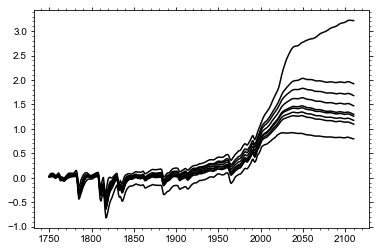

In [53]:
for perc in [0,5,10,20,25,50,75,90,100]:
    pl.plot(np.arange(1750,2111),np.percentile(t,perc, axis=1), color='k')


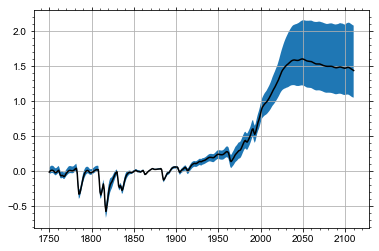

In [54]:
pl.fill_between(np.arange(1750,2111), np.percentile(results_out['CCC_PA']['temp'], 5, axis=1), np.percentile(results_out['CCC_PA']['temp'], 95, axis=1))
pl.plot(np.arange(1750,2111), np.percentile(results_out['CCC_PA']['temp'], 50, axis=1), color='k')
pl.grid()

# Plot the new scenarios on one axis

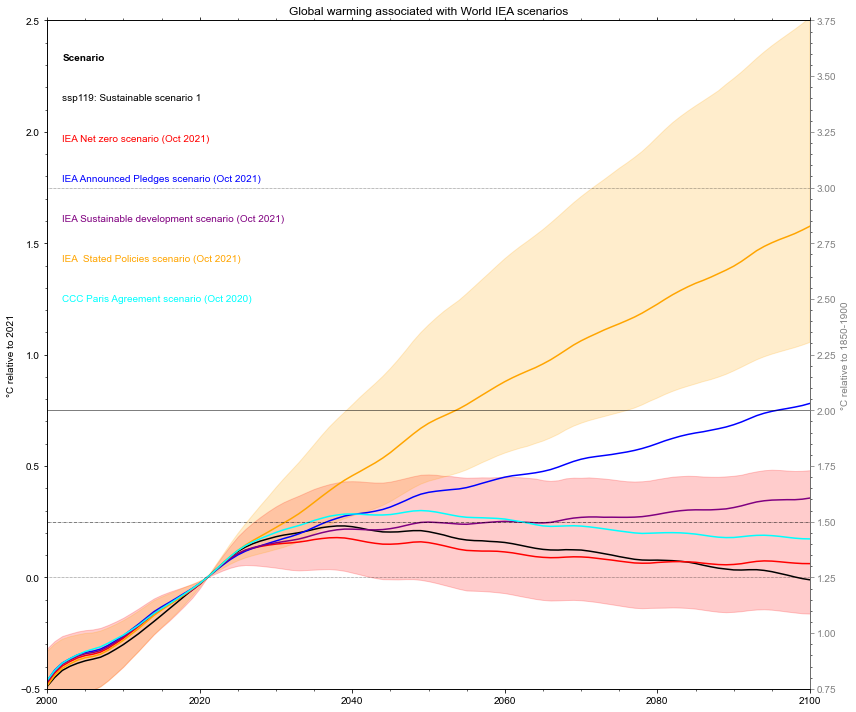

In [55]:
#scenarios = ['zero', 'constant_forcing', 'constant_emissions', 'infrastructure', 'scenario']
scenarios = [ 'ssp119']
colors = {
    'ssp119' : 'black',
    'NZ':'red',
    'APS':'blue',
    'SDS':'purple',
    'STEPS':'orange',
    'CCC_PA':'cyan'
    }

labels = {
    'ssp119':'ssp119: Sustainable scenario 1',
    'NZ':    'IEA Net zero scenario (Oct 2021)',
    'APS':   'IEA Announced Pledges scenario (Oct 2021)',
    'SDS':   'IEA Sustainable development scenario (Oct 2021)',
    'STEPS': 'IEA  Stated Policies scenario (Oct 2021)',
    'CCC_PA':'CCC Paris Agreement scenario (Oct 2020)'
    }

fig, ax = pl.subplots(figsize=(12, 10))

ax.text(0.02, 0.94, 'Scenario', fontweight='bold', fontsize=10, transform=ax.transAxes)
for i, scenario in enumerate(['ssp119', 'NZ',  'APS','SDS', 'STEPS','CCC_PA']):
    if scenario in ['NZ','STEPS']: #,'APS','SDS' ]:
        ax.fill_between(np.arange(2000,2101), np.percentile(results_out[scenario]['temp'][250:351,:] - results_out[scenario]['temp'][271,:], 5, axis=1), np.percentile(results_out[scenario]['temp'][250:351,:] - results_out[scenario]['temp'][271,:], 95, axis=1), color=colors[scenario], alpha=0.2)
    ax.plot(np.arange(2000, 2101), np.median(results_out[scenario]['temp'][250:351,:] - results_out[scenario]['temp'][271,:], axis=1), color=colors[scenario], label=labels[scenario])
    ax.text(0.02, 0.88-0.06*i, labels[scenario], color=colors[scenario], transform=ax.transAxes, fontsize=10)
#ax.legend(fontsize=10);
ax.set_ylabel('°C relative to 2021');
ax.set_title('Global warming associated with World IEA scenarios');
ax.set_xlim(2000, 2100)
ax.set_ylim(-0.5, 2.5)#1.5)

from matplotlib import ticker

ax1 = ax.twinx()
positions = np.arange(0.75, 3.76, 0.25)
#positions = np.arange(0.75, 2.76, 0.25)
#ax1.plot(temp_df.index[150:], temp_df.temp[150:], color='k')
ax1.yaxis.set_major_locator(ticker.FixedLocator(positions))
#ax1[3].xaxis.set_major_formatter(ticker.FixedFormatter(labels))
ax1.set_ylim(0.75,3.75)#2.75)
ax1.spines['right'].set_color('gray')
ax1.tick_params(axis='y', colors='gray')
ax1.set_ylabel('°C relative to 1850-1900', color='gray')
#ax1.set_yticklabels(np.arange(0.75, 2.26, 0.25))
#pl.grid()

ax.axhline(0, ls=':', color='k', lw=0.5)
ax1.axhline(1.5, ls='-.', color='k', lw=0.5)
ax1.axhline(2.0, ls='-', color='k', lw=0.5)
ax1.axhline(3.0, ls=':', color='k', lw=0.5)
fig.tight_layout()
pl.savefig('../plots/cccpa_iea_WEO_scenarios_temp.png', dpi=500, transparent=False)

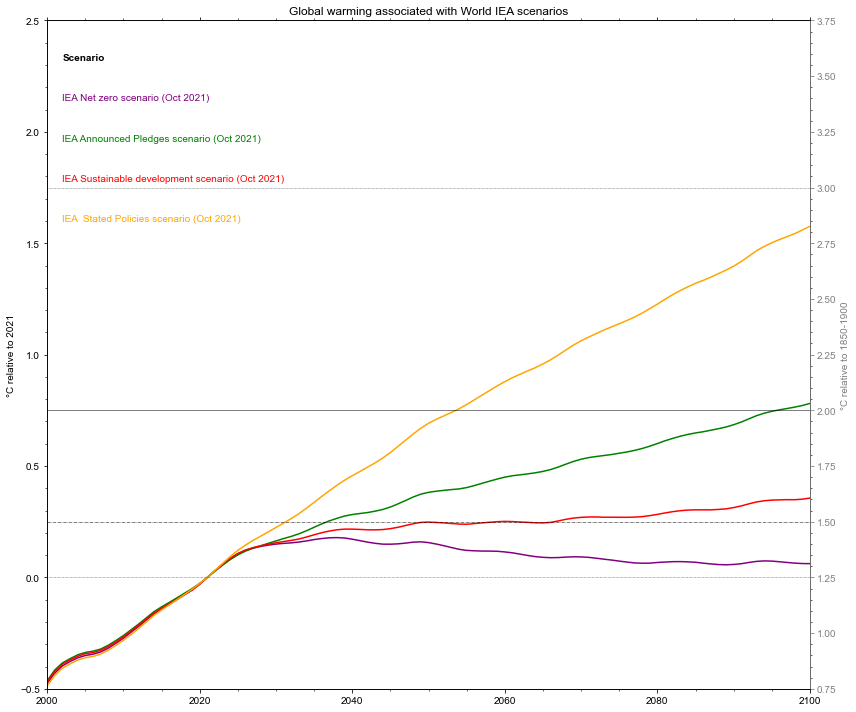

In [56]:
#scenarios = ['zero', 'constant_forcing', 'constant_emissions', 'infrastructure', 'scenario']
scenarios = [ 'ssp119']
colors = {

    'NZ':'purple',
    'APS':'green',
    'SDS':'Red',
    'STEPS':'orange',
    }

labels = {
    'NZ':    'IEA Net zero scenario (Oct 2021)',
    'APS':   'IEA Announced Pledges scenario (Oct 2021)',
    'SDS':   'IEA Sustainable development scenario (Oct 2021)',
    'STEPS': 'IEA  Stated Policies scenario (Oct 2021)',
    }

fig, ax = pl.subplots(figsize=(12, 10))

ax.text(0.02, 0.94, 'Scenario', fontweight='bold', fontsize=10, transform=ax.transAxes)
for i, scenario in enumerate([ 'NZ',  'APS','SDS', 'STEPS']):
    #if scenario in ['NZ','STEPS']: #,'APS','SDS' ]:
    #    ax.fill_between(np.arange(2000,2101), np.percentile(results_out[scenario]['temp'][250:351,:] - results_out[scenario]['temp'][271,:], 5, axis=1), np.percentile(results_out[scenario]['temp'][250:351,:] - results_out[scenario]['temp'][271,:], 95, axis=1), color=colors[scenario], alpha=0.2)
    ax.plot(np.arange(2000, 2101), np.median(results_out[scenario]['temp'][250:351,:] - results_out[scenario]['temp'][271,:], axis=1), color=colors[scenario], label=labels[scenario])
    ax.text(0.02, 0.88-0.06*i, labels[scenario], color=colors[scenario], transform=ax.transAxes, fontsize=10)
#ax.legend(fontsize=10);
ax.set_ylabel('°C relative to 2021');
ax.set_title('Global warming associated with World IEA scenarios');
ax.set_xlim(2000, 2100)
ax.set_ylim(-0.5, 2.5)#1.5)

from matplotlib import ticker

ax1 = ax.twinx()
positions = np.arange(0.75, 3.76, 0.25)
#positions = np.arange(0.75, 2.76, 0.25)
#ax1.plot(temp_df.index[150:], temp_df.temp[150:], color='k')
ax1.yaxis.set_major_locator(ticker.FixedLocator(positions))
#ax1[3].xaxis.set_major_formatter(ticker.FixedFormatter(labels))
ax1.set_ylim(0.75,3.75)#2.75)
ax1.spines['right'].set_color('gray')
ax1.tick_params(axis='y', colors='gray')
ax1.set_ylabel('°C relative to 1850-1900', color='gray')
#ax1.set_yticklabels(np.arange(0.75, 2.26, 0.25))
#pl.grid()

ax.axhline(0, ls=':', color='k', lw=0.5)
ax1.axhline(1.5, ls='-.', color='k', lw=0.5)
ax1.axhline(2.0, ls='-', color='k', lw=0.5)
ax1.axhline(3.0, ls=':', color='k', lw=0.5)
fig.tight_layout()
pl.savefig('../plots/ccc_iea_WEO_scenarios_temp_medians.png', dpi=500, transparent=False)